<a href="https://colab.research.google.com/github/umbertogagl97/Tesi/blob/main/Impronte/AttaccoScanner/Attacco_IFGM_completo_0_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Init**

##Import ART

In [1]:
#importa ART
!pip install adversarial-robustness-toolbox

     |████████████████████████████████| 1.1 MB 7.5 MB/s 
     |████████████████████████████████| 3.3 MB 41.7 MB/s 
     |████████████████████████████████| 26.3 MB 1.2 MB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2


## Import librerie

In [2]:
#Librerie

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
#import time
#import os
#import shutil
#import copy

import pandas as pd
import matplotlib.pyplot as plt
import sys

from torchvision.transforms.functional import InterpolationMode

from torch.utils.data import TensorDataset, DataLoader

import cv2
from google.colab.patches import cv2_imshow

##Check device


In [3]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

1.9.0+cu111
True
Tesla P100-PCIE-16GB
cuda:0


##Transforms

In [4]:
transf_init=transforms.Resize(size=(1000,1000),interpolation=InterpolationMode.NEAREST)

data_transform_test= transforms.Compose([transforms.Resize([224,224],interpolation=InterpolationMode.NEAREST),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])
transf_resize=transforms.Resize([224,224],interpolation=InterpolationMode.NEAREST)

transf_load= transforms.Compose([transforms.ToTensor(),
                                 #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])
trans_norm=transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

##Def path

In [5]:
#scanner
scanner_name = 'HiScan'

#salvataggio modello
model_name = 'VGG19_10epoc_lr5_bs200_adam'
path_model = F"/content/gdrive/My Drive/ModelliCNN/Scanner/{scanner_name}/{model_name}" 

#dataset
pathTestset=F'/content/gdrive/MyDrive/Dataset_impronte/test/{scanner_name}'

pd_preds_value=F'/content/gdrive/MyDrive/Dataset_impronte/test/Preds_value/{scanner_name}_con_normalize.xlsx'

##Collegamento google drive

In [6]:
#collegamento google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#**Dataset**

##Caricamento dataset

In [7]:
test_dataset = datasets.ImageFolder(pathTestset,transform=transf_load)
dim_set=len(test_dataset)
print(dim_set)

2500


##Dataloader

In [8]:
testgen=torch.utils.data.DataLoader(test_dataset, pin_memory=True, batch_size=1,num_workers=2)
print(len(testgen))

2500


##Nomi classi

In [9]:
classes_name=test_dataset.classes
class_number=len(classes_name)
print(classes_name)
print(class_number)
#del test_dataset

['Live', 'Spoof']
2


#**Riduzione dataset**

In [10]:
test_dataset.samples=test_dataset.samples[1004:1005]

dim_set=len(test_dataset)
print(dim_set)

1


In [11]:
a,b=next(iter(testgen))
_min,_max=torch.min(a),torch.max(a)
print(_min,_max)

tensor(0.) tensor(1.)


# **Creazione modello**

> non ho bloccato i parametri inferiori e sbloccato quelli del classificatore, vedi se funziona



##Load model pre-trained

In [12]:
model = models.vgg19(pretrained=True,progress=True)
#model = models.densenet201(pretrained=True,progress=True)
#print(model)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

##Aggiunta classificatore

In [13]:
model.classifier[6]=nn.Linear(4096,2) #per vgg19
#model.classifier=nn.Linear(1920,2) #per densenet201

#print(model) 

##Load pesi

In [14]:
model.load_state_dict(torch.load(path_model))#,map_location=torch.device('cpu')))


<All keys matched successfully>

# **Def funzioni**

##calc size

In [27]:
def calc_size(n):
  '''
  n: int 
  return: 80% of n
  '''
  return tuple(int(np.ceil(i * (80/100))) for i in n)

##Perturbazione

In [28]:
def compute_perturb(x,x_adv):
  '''
    x: img originali
    x_adv: img contraddittorie
    return: pertubazioni, media, perturbazioni normalizzate in [0,1] 
  '''
  if x_adv.shape[2]!=1000:
    x=np.array(transf_resize(torch.Tensor(x)))
  perturb=x_adv-x
  
  if perturb.shape[2]!=1000:
    perturb=np.array(transf_init(torch.Tensor(perturb)))
  #perturb_gray = np.clip(0.2989 * perturb[:,0,:,:] + 0.5870 * perturb[:,1,:,:] + 0.1140 * perturb[:,2,:,:],0,1)
  #print('Average perturbation: {:4.2f}'.format(m))
  
  return perturb

##Print subplot

In [36]:
def print_subplot(perturb,x_test,y_test,preds,x_test_adv,value_preds_adv,normalize=False):
  '''
    x_test: img originali
    y_test: classi originali
    preds: classi predette per img originali
    x_test_adv: img contraddittoria
    value_preds_adv: probabilità predette img contraddittorie
    normalize: se True normalizza le immagini
  '''
  
  if normalize:
    min,max=np.min(x_test),np.max(x_test)
    x_test = (x_test - min) / (max - min)
    min,max=np.min(x_test_adv),np.max(x_test_adv)
    x_test_adv = (x_test_adv - min) / (max - min)


  #perturb,val_pert,perturb_norm=compute_perturb(x_test,x_test_adv)

  #nel seguente ciclo for si crea un vettore delle classi predette ordinato per probabilità decrescente
  for i in range(len(x_test)):#(x_test.shape[0]):
    value=value_preds_adv[i]*100
    value_sorted=sorted(value,reverse=True)
    classes=[]
    for j in range(value.size) :
      ind=np.where(value==value_sorted[j]) #restituisce l'indice in value del valore uguale a value_sorted[i], quindi è la classe
      classes.append(classes_name[ind[0][0]]) #classes è il vettore finale
    
    value_sorted=[ round(elem, 2) for elem in value_sorted ]

    val_pert=np.mean(np.abs(perturb[i]))
    pert_min,pert_max=np.min(perturb[i]),np.max(perturb[i])
    #perturb,val_pert,perturb_norm=compute_perturb(x_test,x_test_adv)
    perturb[i]=np.clip(perturb[i],0,1) #rimuovo i valori negativi poiché non posso visualizzarli
    #in seguito per ogni immagine del test set si stampa un subplot
    fig = plt.figure(figsize=[20,20])
    #plt.subplots_adjust(wspace=0.9)
    print('\033[1m'+"IMMAGINE "+'\033[1m',i) #valore END: '\033[0m'
    #originale
    ax1 = fig.add_subplot(131) #subplot con 3 righe e due colonne
    ax1.axis('off')
    #ax1.imshow(cv2.rotate(x_test[i],cv2.cv2.ROTATE_90_CLOCKWISE))
    ax1.imshow(x_test[i].transpose(1,2,0))
    ax1.title.set_text("ORIGINALE\nclasse reale: "+classes_name[np.argmax(y_test[i])]+"\nclasse predetta: "+str(classes_name[preds[i]]))
    #perturbazione
    ax2 = fig.add_subplot(132)
    #ax2.imshow(cv2.rotate(perturb_norm[i],cv2.cv2.ROTATE_90_CLOCKWISE))
    ax2.imshow(perturb[i].transpose(1,2,0),cmap='gray')
    #ax2.imshow(perturb[i],cmap='gray')
    ax2.axis('off')
    ax2.title.set_text("PERTURBAZIONE\nvalore medio: "+str(round(val_pert,4))+"\nmin: "+str(pert_min)+"\nmax: "+str(pert_max))
    #perturbata
    ax3 = fig.add_subplot(133)
    #ax3.imshow(cv2.rotate(x_test_adv[i],cv2.cv2.ROTATE_90_CLOCKWISE))#,aspect='auto')
    ax3.imshow(x_test_adv[i].transpose(1,2,0))
    ax3.axis('off')
    ax3.title.set_text("PERTURBATA\nclassi predette: "+str(classes)+"\ncon valori: "+str(value_sorted))
    plt.show()

##Testing

con media senza datframe

In [30]:
def test_average_preds(classifier,input):
  '''
  model: model trained
  test_loader: dataloader 
  return: pred: classe predetta, probabilities: probabilità per entrambe le classi
  '''
  preds=[]
  #value=[]
  prob=nn.Softmax()
  
  if input.shape[2]!=1000:
    input=transf_init(input)

  n=input.shape
  n_mod=calc_size(n[2:4])
  crop_transform=transforms.TenCrop((n_mod[0],n_mod[1]))
  crops=crop_transform(input)
  live=0
  spoof=0
  for crop in crops:
    crop=data_transform_test(crop) #resize 224
    outputs = classifier.predict(crop)
    live+=outputs[0][0]
    spoof+=outputs[0][1]
  live=live/10
  spoof=spoof/10
  predicted=np.argmax([live,spoof])
  probabilities=prob(torch.Tensor([live,spoof])).numpy()

  return predicted,probabilities

In [31]:
def test_average_values(classifier,input):
  '''
  model: model trained
  test_loader: dataloader 
  return: pred: classe predetta, probabilities: probabilità per entrambe le classi
  '''
  preds=[]
  #value=[]
  
  if input.shape[2]!=1000:
    input=transf_init(input)

  n=input.shape
  n_mod=calc_size(n[2:4])
  crop_transform=transforms.TenCrop((n_mod[0],n_mod[1]))
  crops=crop_transform(input)
  live=0
  spoof=0
  for crop in crops:
    crop=data_transform_test(crop) #resize 224
    outputs = classifier.predict(crop)
    live+=outputs[0][0]
    spoof+=outputs[0][1]
  live=live/10
  spoof=spoof/10
  predicted=np.argmax([live,spoof])
  values=[live,spoof]

  return predicted,values

##Array to dataloader

In [32]:
def array2dataloader(x,y):
  '''
  :param x: ndarray x_test;
  :param y: labels
  '''
  tensor_x = torch.Tensor(x) # transform to torch tensor
  tensor_y = torch.Tensor(np.argmax(y,axis=1))

  my_dataset = TensorDataset(tensor_x,tensor_y) # create your datset
  return DataLoader(my_dataset) 

##mask

In [33]:
def compute_mask(img):
  #img iniziale [0,1]
  img=np.array(img[0])
  img=img.transpose(1,2,0)

  #trasforma in gray
  r, g, b = img[:,:,0], img[:,:,1], img[:,:,2]
  gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
  #scala in [0,255]
  gray = (gray - np.min(gray)) / (np.max(gray) - np.min(gray))
  gray=gray*255
  gray=gray.astype('uint8')
  #calcola immagine binaria
  ret, imgf = cv2.threshold(gray, 0,255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

  image_contours = np.zeros((imgf.shape[1],
                            imgf.shape[0]),
                            np.uint8)

  image_binary = np.zeros((imgf.shape[1],
                          imgf.shape[0]),
                          np.uint8)

  #cerca i contorni nell'immagine binaria
  contours =cv2.findContours(imgf, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]
  cv2.drawContours(image_contours,
                      contours, -1,
                      (255,255), 3)

  contours = cv2.findContours(image_contours, cv2.RETR_LIST,
                            cv2.CHAIN_APPROX_SIMPLE)[0]
  #disegna solo il contorno più esterno
  cv2.drawContours(image_binary, [max(contours, key = cv2.contourArea)],
                  -1, (255, 255),-1)
  #restituisce immagine [0,1]
  return ((image_binary-np.min(image_binary))/(np.max(image_binary)-np.min(image_binary)))

##FGM mod

In [34]:
from __future__ import absolute_import, division, print_function, unicode_literals

import logging
from typing import Optional, Union, TYPE_CHECKING

import numpy as np

from art.config import ART_NUMPY_DTYPE
from art.attacks.attack import EvasionAttack
from art.estimators.estimator import BaseEstimator, LossGradientsMixin
from art.estimators.classification.classifier import ClassifierMixin
from art.utils import (
    compute_success,
    get_labels_np_array,
    random_sphere,
    projection,
    check_and_transform_label_format,
)

if TYPE_CHECKING:
    from art.utils import CLASSIFIER_LOSS_GRADIENTS_TYPE

logger = logging.getLogger(__name__)


class IterativeFastGradientMethod(EvasionAttack):
    """
    This attack was originally implemented by Goodfellow et al. (2015) with the infinity norm (and is known as the "Fast
    Gradient Sign Method"). This implementation extends the attack to other norms, and is therefore called the Fast
    Gradient Method.
    | Paper link: https://arxiv.org/abs/1412.6572
    """

    attack_params = EvasionAttack.attack_params + [
        "norm",
        "eps",
        "eps_step",
        "tensor_board",
    ]
    _estimator_requirements = (BaseEstimator, LossGradientsMixin)

    def __init__(
        self,
        estimator: "CLASSIFIER_LOSS_GRADIENTS_TYPE",
        norm: Union[int, float, str] = np.inf,
        eps: Union[int, float, np.ndarray] = 0.3,
        eps_step: Union[int, float, np.ndarray] = 0.1,
        tensor_board: Union[str, bool] = False,
    ) -> None:
        """
        Create a :class:`.FastGradientMethod` instance.
        :param estimator: A trained classifier.
        :param norm: The norm of the adversarial perturbation. Possible values: "inf", np.inf, 1 or 2.
        :param eps: Attack step size (input variation).
        :param eps_step: Step size of input variation for minimal perturbation computation.
        :param tensor_board: Activate summary writer for TensorBoard: Default is `False` and deactivated summary writer.
                             If `True` save runs/CURRENT_DATETIME_HOSTNAME in current directory. Provide `path` in type
                             `str` to save in path/CURRENT_DATETIME_HOSTNAME.
                             Use hierarchical folder structure to compare between runs easily. e.g. pass in ‘runs/exp1’,
                             ‘runs/exp2’, etc. for each new experiment to compare across them.
        """
        super().__init__(estimator=estimator, tensor_board=tensor_board)
        self.norm = norm
        self.eps = eps
        self.eps_step = eps_step
        self._project = True
        IterativeFastGradientMethod._check_params(self)

        self._i_max_iter = 0

    def _check_compatibility_input_and_eps(self, x: np.ndarray):
        """
        Check the compatibility of the input with `eps` and `eps_step` which are of the same shape.
        :param x: An array with the original inputs.
        """
        if isinstance(self.eps, np.ndarray):
            # Ensure the eps array is broadcastable
            if self.eps.ndim > x.ndim:
                raise ValueError("The `eps` shape must be broadcastable to input shape.")

    def _minimal_perturbation(self, x: np.ndarray, y: np.ndarray, class_target, max_iter, confidence) -> np.ndarray:
        """
        Iteratively compute the minimal perturbation necessary to make the class prediction change. Stop when the
        first adversarial example was found.
        :param x: An array with the original inputs.
        :param y: Target values (class labels) one-hot-encoded of shape (nb_samples, nb_classes).
        :param class_target: class da predire se target=True (nel nostro caso vogliamo far predire sempre live)
        :return: An array holding the adversarial examples.
        """
        adv_x = x.copy()
        
        pred,values=test_average_preds(self.estimator,torch.Tensor(adv_x))
        if ((pred==np.argmax(y, axis=1)) and (pred!= class_target)):
           active=True
        elif ((pred!=np.argmax(y, axis=1)) and (pred== class_target) and (np.max(values)<confidence)): 
           active=True
        else:  active=False

        current_eps = self.eps_step
        partial_stop_condition = current_eps <= self.eps
            
        iter=0
        #ridimensionamento per le img spoof spoof
        if active==True:
          adv_x=transf_resize(torch.Tensor(adv_x))
          #inserisci qui calcolo mask
          mask_mod=compute_mask(torch.Tensor(adv_x)) #è un'immagine 224x224 in scala di grigi
          
          adv_x=np.array(adv_x) #[0,1]
          
          #print("x init")
          #print(np.max(adv_x),np.min(adv_x))
          while active==True and partial_stop_condition and iter<max_iter:
                iter+=1
                #calcolo perturbazione
                perturbation = self._compute_perturbation(adv_x, y, mask_mod) #[-1,1]
                #trasformo in gray
                r, g, b = perturbation[0,0,:,:],perturbation[0,1,:,:],perturbation[0,2,:,:]
                perturbation = 0.2989 * r + 0.5870 * g + 0.1140 * b
                #normalizzo pert gray in 0,1
                #perturbation=(perturbation-np.min(perturbation))/(np.max(perturbation)-np.min(perturbation))
                #perturbation=(perturbation*255).astype('uint8')
                
                #applico la maschera alla perturb
                #pert_mask=perturbation*mask_mod
                
                #applico la perturb al batch
                current_x = self._apply_perturbation(adv_x, perturbation, current_eps)
                #print("x_final")
                #print(np.max(current_x),np.min(current_x))
                # Update
                #batch[active_indices] = current_x[active_indices]
                
                adv_x = current_x
                pred,values=test_average_preds(self.estimator,torch.Tensor(adv_x))
                #print(preds,value)
                #print(batch_labels)
                # If targeted active check to see whether we have hit the target, otherwise head to anything but
                if ((pred==np.argmax(y, axis=1)) and (pred!= class_target)):
                  active=True
                elif ((pred!=np.argmax(y, axis=1)) and (pred== class_target) and (np.max(values)<confidence)): 
                  active=True
                else:  active=False

                # Update current eps and check the stop condition
                current_eps = current_eps + self.eps_step
                partial_stop_condition = current_eps <= self.eps

        return adv_x

    def generate(self, x: np.ndarray, y: Optional[np.ndarray] = None, class_target=0, max_iter=10, confidence=0.6, **kwargs) -> np.ndarray:
        """Generate adversarial samples and return them in an array.
        :param x: An array with the original inputs.
        :param y: Target values (class labels) one-hot-encoded of shape (nb_samples, nb_classes) or indices of shape
                  (nb_samples,). Only provide this parameter if you'd like to use true labels when crafting adversarial
                  samples. Otherwise, model predictions are used as labels to avoid the "label leaking" effect
                  (explained in this paper: https://arxiv.org/abs/1611.01236). Default is `None`.
        :param class_target: se target=True specifica quale classe far predire.
        :param max_iter: numero massimo di iterazioni da effettuare su ogni singolo batch nel caso minimal.
        :param confidence: indica la probabilità minima con la quale il classificatore deve predire una classe affinché l'attacco si arresti.          
        :return: An array holding the adversarial examples.
        """

        # Ensure eps is broadcastable
        self._check_compatibility_input_and_eps(x=x)

        y = check_and_transform_label_format(y, self.estimator.nb_classes)

        if y is None:
           # Throw error if attack is targeted, but no targets are provided
           # Use model predictions as correct outputs
           logger.info("Using model predictions as correct labels for FGM.")
           y = get_labels_np_array(self.estimator.predict(x))  # type: ignore

        # Return adversarial examples computed with minimal perturbation if option is active
        adv_x_best = self._minimal_perturbation(x, y, class_target, max_iter, confidence)
        
        return adv_x_best

    def _check_params(self) -> None:

        if self.norm not in [1, 2, np.inf, "inf"]:
            raise ValueError('Norm order must be either 1, 2, `np.inf` or "inf".')

        if not (
            isinstance(self.eps, (int, float))
            and isinstance(self.eps_step, (int, float))
            or isinstance(self.eps, np.ndarray)
            and isinstance(self.eps_step, np.ndarray)
        ):
            raise TypeError(
                "The perturbation size `eps` and the perturbation step-size `eps_step` must have the same type of `int`"
                ", `float`, or `np.ndarray`."
            )

        if isinstance(self.eps, (int, float)):
            if self.eps < 0:
                raise ValueError("The perturbation size `eps` has to be nonnegative.")
        else:
            if (self.eps < 0).any():
                raise ValueError("The perturbation size `eps` has to be nonnegative.")

        if isinstance(self.eps_step, (int, float)):
            if self.eps_step <= 0:
                raise ValueError("The perturbation step-size `eps_step` has to be positive.")
        else:
            if (self.eps_step <= 0).any():
                raise ValueError("The perturbation step-size `eps_step` has to be positive.")

        if isinstance(self.eps, np.ndarray) and isinstance(self.eps_step, np.ndarray):
            if self.eps.shape != self.eps_step.shape:
                raise ValueError(
                    "The perturbation size `eps` and the perturbation step-size `eps_step` must have the same shape."
                )

    def _compute_perturbation(
        self, batch: np.ndarray, batch_labels: np.ndarray, mask: Optional[np.ndarray]
    ) -> np.ndarray:
        # Pick a small scalar to avoid division by 0
        tol = 10e-8
        batch=np.array(trans_norm(torch.Tensor(batch)))
        # Get gradient wrt loss; invert it if attack is targeted
        grad = self.estimator.loss_gradient(batch, batch_labels)

        # Check for NaN before normalisation an replace with 0
        if grad.dtype != np.object and np.isnan(grad).any():
            logger.warning("Elements of the loss gradient are NaN and have been replaced with 0.0.")
            grad = np.where(np.isnan(grad), 0.0, grad)
        else:
            for i, _ in enumerate(grad):
                grad_i_array = grad[i].astype(np.float32)
                if np.isnan(grad_i_array).any():
                    grad[i] = np.where(np.isnan(grad_i_array), 0.0, grad_i_array).astype(np.object)

        # Apply mask
        if mask is not None:
            grad = np.where(mask == 0.0, 0.0, grad)

        # Apply norm bound
        def _apply_norm(grad, object_type=False):
            if (grad.dtype != np.object and np.isinf(grad).any()) or np.isnan(grad.astype(np.float32)).any():
                logger.info("The loss gradient array contains at least one positive or negative infinity.")

            if self.norm in [np.inf, "inf"]:
                grad = np.sign(grad)
            elif self.norm == 1:
                if not object_type:
                    ind = tuple(range(1, len(batch.shape)))
                else:
                    ind = None
                grad = grad / (np.sum(np.abs(grad), axis=ind, keepdims=True) + tol)
            elif self.norm == 2:
                if not object_type:
                    ind = tuple(range(1, len(batch.shape)))
                else:
                    ind = None
                grad = grad / (np.sqrt(np.sum(np.square(grad), axis=ind, keepdims=True)) + tol)
            return grad

        if batch.dtype == np.object:
            for i_sample in range(batch.shape[0]):
                grad[i_sample] = _apply_norm(grad[i_sample], object_type=True)
                assert batch[i_sample].shape == grad[i_sample].shape
        else:
            grad = _apply_norm(grad)

        assert batch.shape == grad.shape

        return grad

    def _apply_perturbation(
        self, batch: np.ndarray, perturbation: np.ndarray, eps_step: Union[int, float, np.ndarray]
    ) -> np.ndarray:

        perturbation_step = eps_step * perturbation
        if perturbation_step.dtype != np.object:
            perturbation_step[np.isnan(perturbation_step)] = 0
        else:
            for i, _ in enumerate(perturbation_step):
                perturbation_step_i_array = perturbation_step[i].astype(np.float32)
                if np.isnan(perturbation_step_i_array).any():
                    perturbation_step[i] = np.where(
                        np.isnan(perturbation_step_i_array), 0.0, perturbation_step_i_array
                    ).astype(np.object)
                    
        #batch = batch + perturbation_step
        for i in range(3):
          batch[0,i,:,:] = batch[0,i,:,:] + perturbation_step #applica la perturbazione grayscale ad ogni canale delle immagini originali
        if self.estimator.clip_values is not None:
            clip_min, clip_max = self.estimator.clip_values
            batch = np.clip(batch, clip_min, clip_max)

        return batch

# **Esecuzione**

##Creazione classificatore ART Pytorch



In [23]:
from art.estimators.classification import PyTorchClassifier

classifier = PyTorchClassifier(
    model=model,
    clip_values=(_min,_max),
    loss=nn.CrossEntropyLoss(),
    optimizer=optim.Adam(model.classifier.parameters(),lr=1e-5),
    input_shape=(224, 224, 3),
    nb_classes=class_number
)

##Attacco

In [24]:
from art.utils import to_categorical
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import random
# FGM
attack = IterativeFastGradientMethod(estimator=classifier, eps=1000,eps_step=0.001)

list_print=sorted(random.sample(range(dim_set),1))

x_print=[]
y_print=[]
x_print_adv=[] 
y_print_adv=[] 
perturb_print=[]
Test_p = pd.DataFrame()
model.eval()
model.cuda()

i=0
for input,label in testgen:
  i+=1

  sys.stdout.write("\rElem: {0}/{1}".format(i,len(testgen)))
  sys.stdout.flush()

  y_test=np.array((to_categorical(label.numpy(),2)))
  x_test=np.array(input.numpy())
  #cv2.imwrite("img_orig.png",x_test[0].transpose(1,2,0)*255)
  x_test_adv=attack.generate(x=x_test,y=y_test,class_target=classes_name.index('Live'),max_iter=100,confidence=0.7)
  perturb=compute_perturb(x_test[0],x_test_adv[0])

  #x_test_adv=x_test_adv[0,:,:,:]
  #x_test_adv=(x_test_adv-np.min(x_test_adv))/(np.max(x_test_adv)-np.min(x_test_adv))
  
  x_test_adv=torch.Tensor(x_test_adv)
  #x_test_adv=x_test_adv.unsqueeze_(0)
  
  if x_test_adv.shape[2]!=1000:
    x_test_adv=transf_init(x_test_adv)

  pred,probabilities=test_average_preds(classifier,x_test_adv)
  Test_p = Test_p.append({'real': classes_name[int(label)] ,
                          'predicted': classes_name[pred], #qui metti pred
                          'prob_live': round(probabilities[0],4),
                          'prob_spoof': round(probabilities[1],4)},ignore_index = True)

  #print
  if i-1 in list_print:
    x_print.append(x_test[0])
    x_print_adv.append(x_test_adv[0].numpy())
    y_print.append(y_test)
    y_print_adv.append(probabilities)
    perturb_print.append(perturb)
#ora inizio: 20:57-> fine: 22:24

Elem: 1/1

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


##Testing

> Trasforma i due testing in una funzione e richiamala due volte



###Print accuracy test orig from file & load pd

In [ ]:
Test_orig=pd.read_excel(pd_preds_value)
true_label = Test_orig.real.values
predicted = Test_orig.predicted.values
accuracy=round((np.sum((true_label == predicted).astype(int)))/Test_orig.shape[0],4)*100
print("\nAccuracy: {0}".format(accuracy))
print("Shape dataframe: {0}".format(Test_orig.shape))  


Accuracy: 93.76
Shape dataframe: (2500, 4)


###Testing immagini spoof predette live prima e dopo

####Accuracy adv

In [ ]:
true_label = Test_p.real.values
predicted = Test_p.predicted.values
accuracy=round((np.sum((true_label == predicted).astype(int)))/Test_p.shape[0],4)*100
print("\nAccuracy: {0}".format(accuracy))
print("Shape dataframe: {0}".format(Test_p.shape)) 


Accuracy: 0.27
Shape dataframe: (1500, 4)


####Spoof

In [ ]:
print(Test_orig)
n_spoof=np.sum(Test_orig['real']=='Spoof')
print("# img spoof: "+str(n_spoof))

     predicted   real  value_pred_live  value_pred_spoof
0         Live   Live         6.631882         -5.174079
1         Live   Live         7.300115         -6.452907
2         Live   Live         9.761596         -9.069071
3         Live   Live        10.803438         -9.714268
4         Live   Live         7.850704         -7.007375
...        ...    ...              ...               ...
2495     Spoof  Spoof        -6.569155          8.471490
2496     Spoof  Spoof        -7.230628          8.972368
2497     Spoof  Spoof        -4.387788          5.860938
2498     Spoof  Spoof        -6.238798          8.079524
2499     Spoof  Spoof        -6.456174          8.300977

[2500 rows x 4 columns]
# img spoof: 1500


prima

In [ ]:
p=Test_orig.loc[Test_orig['real']=='Spoof']
p1=p.loc[p['predicted']==p['real']]
print("Img realmente spoof e predette spoof")
print(p1)
n_spoof_pred=p1.count(0)[0]
print("Numero di predizioni spoof giuste: "+str(n_spoof_pred))
print("Accuracy su img spoof: "+str(round(n_spoof_pred/n_spoof*100,2)))

Img realmente spoof e predette spoof
     predicted   real  value_pred_live  value_pred_spoof
1000     Spoof  Spoof        -6.478349          7.893529
1001     Spoof  Spoof        -5.261711          7.206484
1002     Spoof  Spoof        -5.208933          6.696104
1003     Spoof  Spoof        -2.940028          4.300073
1004     Spoof  Spoof        -5.451423          6.697002
...        ...    ...              ...               ...
2495     Spoof  Spoof        -6.569155          8.471490
2496     Spoof  Spoof        -7.230628          8.972368
2497     Spoof  Spoof        -4.387788          5.860938
2498     Spoof  Spoof        -6.238798          8.079524
2499     Spoof  Spoof        -6.456174          8.300977

[1460 rows x 4 columns]
Numero di predizioni spoof giuste: 1460
Accuracy su img spoof: 97.33


dopo

In [ ]:
d=Test_p.loc[Test_p['real']=='Spoof']
d1=d.loc[d['predicted']==d['real']]
print("Img realmente spoof e predette spoof")
print(d1)
n_spoof_pred2=d1.count(0)[0]
print("Numero di predizioni spoof giuste: "+str(n_spoof_pred2))
print("Accuracy su img spoof: "+str(round(n_spoof_pred2/n_spoof*100,2)))

Img realmente spoof e predette spoof
     predicted  prob_live  prob_spoof   real
368      Spoof     0.0032      0.9968  Spoof
975      Spoof     0.0020      0.9980  Spoof
1385     Spoof     0.0004      0.9996  Spoof
1395     Spoof     0.0000      1.0000  Spoof
Numero di predizioni spoof giuste: 4
Accuracy su img spoof: 0.27


####Live

In [ ]:
print(Test_orig)
n_live=np.sum(Test_orig['real']=='Live')
print("# img live: "+str(n_live))

     predicted   real  value_pred_live  value_pred_spoof
0         Live   Live         6.631882         -5.174079
1         Live   Live         7.300115         -6.452907
2         Live   Live         9.761596         -9.069071
3         Live   Live        10.803438         -9.714268
4         Live   Live         7.850704         -7.007375
...        ...    ...              ...               ...
2495     Spoof  Spoof        -6.569155          8.471490
2496     Spoof  Spoof        -7.230628          8.972368
2497     Spoof  Spoof        -4.387788          5.860938
2498     Spoof  Spoof        -6.238798          8.079524
2499     Spoof  Spoof        -6.456174          8.300977

[2500 rows x 4 columns]
# img live: 1000


prima

In [ ]:
p=Test_orig.loc[Test_orig['real']=='Live']
p1=p.loc[p['predicted']==p['real']]
print("Img realmente live e predette live")
print(p1)
n_live_pred=p1.count(0)[0]
print("Numero di predizioni live giuste: "+str(n_live_pred))
print("Accuracy su img live: "+str(round(n_live_pred/n_live*100,2)))

Img realmente live e predette live
    predicted  real  value_pred_live  value_pred_spoof
0        Live  Live         6.631882         -5.174079
1        Live  Live         7.300115         -6.452907
2        Live  Live         9.761596         -9.069071
3        Live  Live        10.803438         -9.714268
4        Live  Live         7.850704         -7.007375
..        ...   ...              ...               ...
987      Live  Live         2.273366         -1.226741
988      Live  Live         4.164461         -3.482738
989      Live  Live         3.149037         -2.271925
996      Live  Live         0.576958          0.442663
999      Live  Live         0.761373          0.349137

[884 rows x 4 columns]
Numero di predizioni live giuste: 884
Accuracy su img live: 88.4


dopo

In [ ]:
d=Test_p.loc[Test_p['real']=='Live']
d1=d.loc[d['predicted']==d['real']]
print("Img realmente live e predette live")
print(d1)
n_live_pred2=d1.count(0)[0]
print("Numero di predizioni live giuste: "+str(n_live_pred2))
print("Accuracy su img live: "+str(round(n_live_pred2/n_live*100,2)))

Img realmente live e predette live
Empty DataFrame
Columns: [predicted, prob_live, prob_spoof, real]
Index: []
Numero di predizioni live giuste: 0
Accuracy su img live: 0.0


####numero img spoof predette live con prob >70%

In [ ]:
p=Test_p.loc[Test_p['real']=='Spoof']
p=p.loc[p['predicted']=='Live']
print("img spoof-live: "+str(p.count(0)[0]))
p=p.loc[p['prob_live']>=0.7]
print("img con prob_live>70%: "+str(p.count(0)[0]))

img spoof-live: 1496
img con prob_live>70%: 1495


##subplot

In [ ]:
print(list_print)

[33, 502, 632, 983, 1134, 1283, 1364, 1383, 1421, 1481]


In [25]:
x_print=np.array(x_print)
y_print=np.array(y_print)
x_print_adv=np.array(x_print_adv)
y_print_adv=np.array(y_print_adv)
perturb_print=np.array(perturb_print)

In [ ]:
print(x_print_adv.shape)

(10, 3, 1000, 1000)


In [ ]:
#da usare nel test finale
preds_orig=Test_orig[1000:].predicted.values[list_print]
print(preds_orig)
print_subplot(perturb_print,x_print,y_print,preds_orig,x_print_adv,y_print_adv,normalize=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


IMMAGINE  0


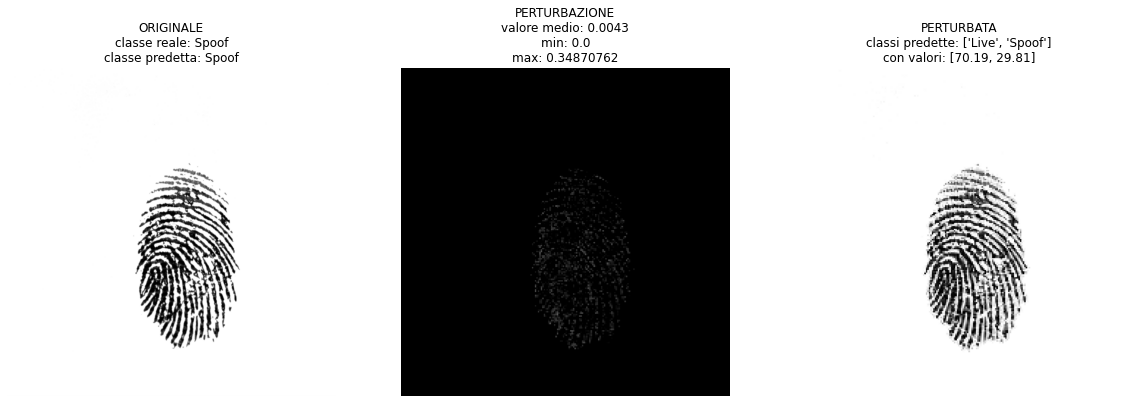

In [37]:
#da usare solo con dataset ridotto
preds_orig=[]
for input,_ in testgen:
  preds_orig_i,_=test_average_preds(classifier,input)
  preds_orig.append(preds_orig_i)
preds_orig=np.array(preds_orig)
preds_orig=preds_orig[list_print]
print_subplot(perturb_print,x_print,y_print,preds_orig,x_print_adv,y_print_adv,normalize=False)

#prova salvataggio e lettura immagine

0.0 255.0


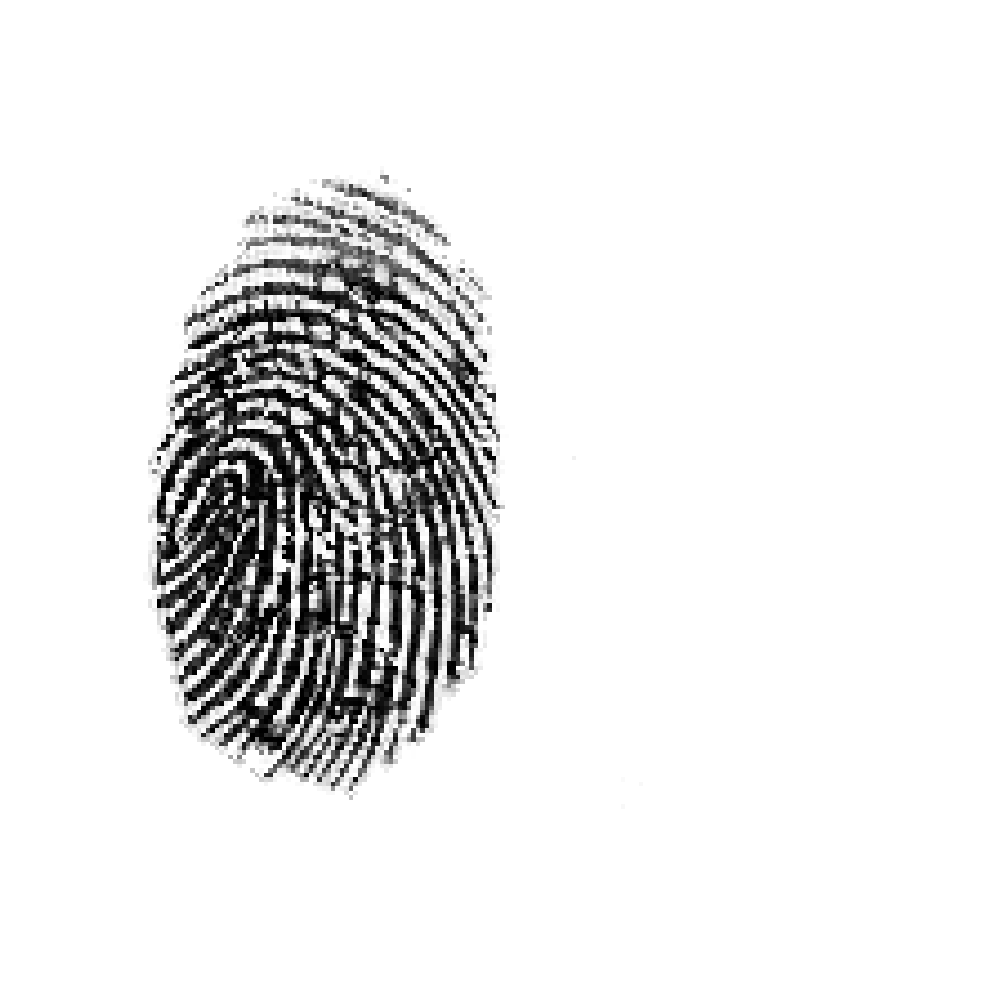

(0, [0.9400165408849717, -0.045182883739471436])

In [ ]:
from PIL import Image
i=0
arr_init=x_print_adv[i].transpose(1,2,0)
#arr_init=(arr_init-np.min(arr_init))/(np.max(arr_init)-np.min(arr_init))
arr_init=(arr_init*255)
print(np.min(arr_init),np.max(arr_init))
#plt.imsave('prova.bmp',arr_init)
cv2.imwrite('prova.png',arr_init)
#plt.imshow(arr_init)
cv2_imshow(arr_init)
test_average_values(classifier,torch.Tensor(x_print_adv[i]).unsqueeze_(0))

0.0 1.0


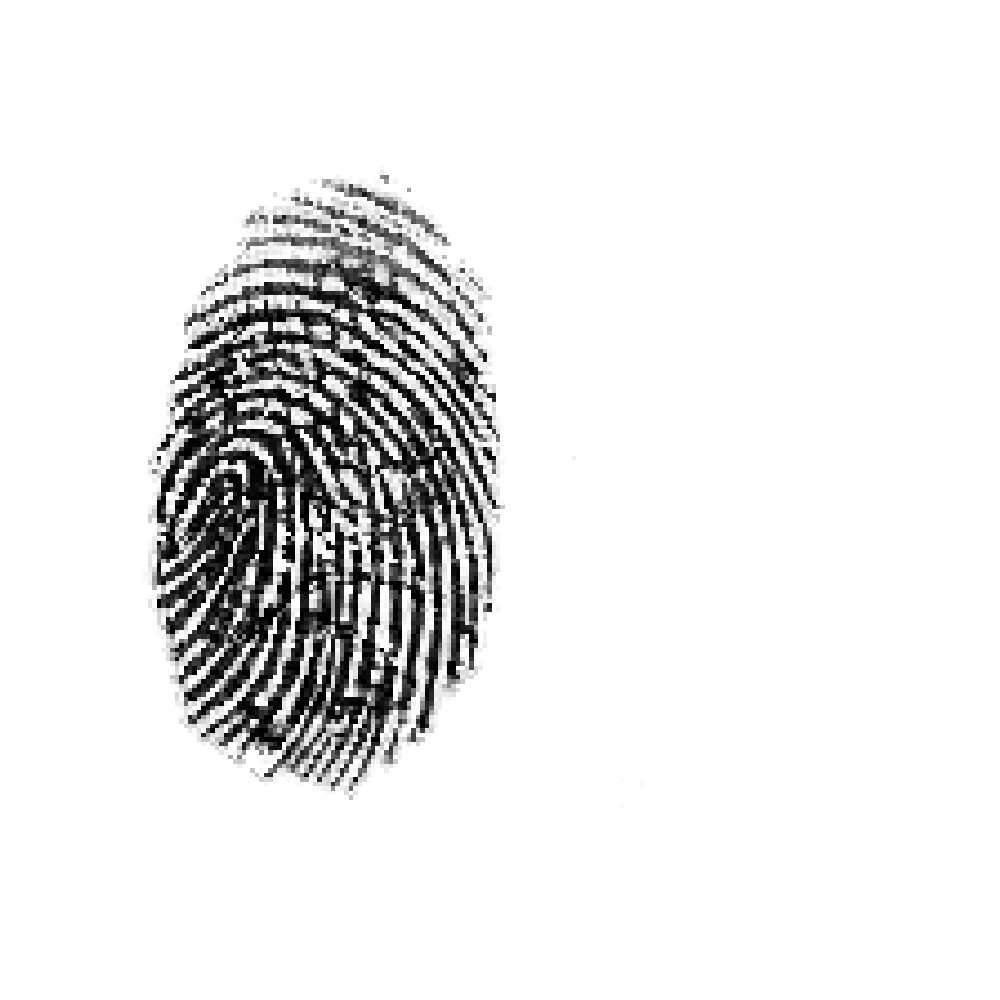

(0, [0.9463125064969062, -0.050324706733226775])

In [ ]:
prova_arr=cv2.imread('prova.png')
prova_arr=prova_arr/255
#prova_arr=plt.imread('prova.bmp')
#prova_arr=(prova_arr-np.min(prova_arr))/(np.max(prova_arr)-np.min(prova_arr))
print(np.min(prova_arr),np.max(prova_arr))
#plt.imshow(prova_arr*255)
cv2_imshow(prova_arr*255)
test_average_values(classifier,torch.Tensor(prova_arr.transpose(2,0,1)).unsqueeze_(0))